***1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)***

In [93]:
import matplotlib.pyplot as plt
import random
import time
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [94]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)
# classification_data, classification_labels = make_circles(n_samples=30, random_state=5)

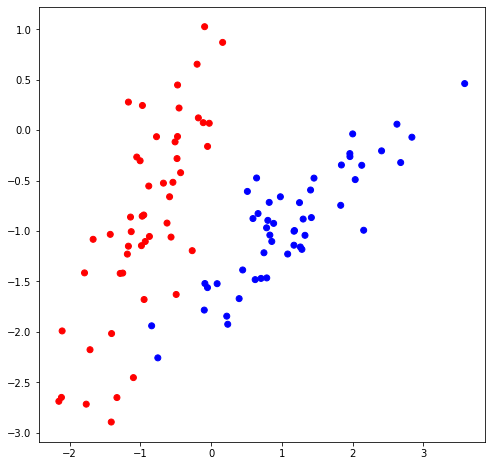

In [95]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [96]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [97]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [98]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [99]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [100]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [101]:
# Нахождение наилучшего разбиения                                                                  

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле        
    # min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            # if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                # continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [102]:
# Построение дерева с помощью рекурсивной функции                                                     !!!ИЗМЕНЕНИЯ!!!

def build_tree(data, labels, depth=4, сurrent_depth=1): # ДОБАВИЛИ ПАРАМЕТРЫ depth (максимальная глубина) и сurrent_depth

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста качества ИЛИ ГЛУБИНА ДЕРЕВА ДОСТИГЛА МАКСИМУМА
    if gain == 0 or сurrent_depth > depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, сurrent_depth = сurrent_depth + 1)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, сurrent_depth = сurrent_depth + 1)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [103]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [104]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [105]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [106]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [107]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Индекс 0 <= -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0 <= -0.4942656820712277
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [108]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [109]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [110]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [111]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [112]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

In [113]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

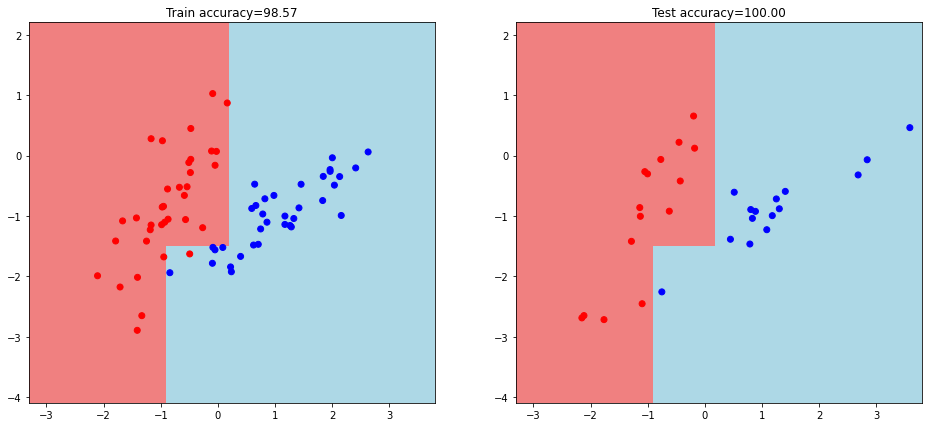

In [114]:
visualize(train_data, test_data)

****2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.***

In [142]:
# Реализуем класс узла - без изменений

class Node_2:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [143]:
class Leaf_regression:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):            
        # найдем среднее значение по выборке и вернем его   
        prediction = np.mean(self.labels)
        return prediction   

In [144]:
def values_variance(array):
    mean = array.mean()
    return np.mean((array - mean)**2)

In [145]:
# Расчет прироста   МЕНЯЕМ НАЗВАНИЕ ПЕРЕМЕННОЙ root_gini --> root_var и функцию gini на values_variance

def gain_2(left_labels, right_labels, root_var):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_var - p * values_variance(left_labels) - (1 - p) * values_variance(right_labels)

In [146]:
# Разбиение датасета в узле

def split_2(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [147]:
# Нахождение наилучшего разбиения                                                                  

def find_best_split_2(data, labels):
    
    #  обозначим минимальное количество объектов в узле        
    min_samples_leaf = 5

    root_var = values_variance(labels) # заменили функцию gini на values_variance

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split_2(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain_2(true_labels, false_labels, root_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [155]:
# Построение дерева с помощью рекурсивной функции                                                    

def build_tree_2(data, labels): 

    gain, t, index = find_best_split_2(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста качества ИЛИ ГЛУБИНА ДЕРЕВА ДОСТИГЛА МАКСИМУМА
    if gain == 0:
        return Leaf_regression(data, labels)

    true_data, false_data, true_labels, false_labels = split_2(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_2(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree_2(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node_2(index, t, true_branch, false_branch)

In [156]:
def classify_object_2(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf_regression):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object_2(obj, node.true_branch)
    else:
        return classify_object_2(obj, node.false_branch)

In [157]:
def predict_2(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object_2(obj, tree)
        classes.append(prediction)
    return classes

In [158]:
# сгенерируем данные

regression_data, target_values = make_regression(n_features=2, n_informative=2, random_state=5)

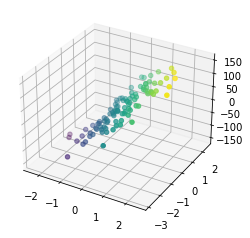

In [159]:
# визуализируем сгенерированные данные

ax = plt.axes(projection='3d')

zdata = target_values
xdata = list(map(lambda x: x[0], regression_data))
ydata = list(map(lambda x: x[1], regression_data))
ax.scatter3D(xdata, ydata, zdata, c=zdata)

In [160]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(regression_data, 
                                                                    target_values, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [161]:
# Построим дерево по обучающей выборке
new_tree = build_tree_2(train_data, train_target)

In [163]:
# Напечатаем ход нашего дерева
def print_tree_2(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf_regression):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree_2(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree_2(node.false_branch, spacing + "  ")
    
print_tree_2(new_tree)

Индекс 0 <= -0.10061434630710828
--> True:
  Индекс 0 <= -0.8568531547160899
  --> True:
    Прогноз: -109.75655471490919
  --> False:
    Индекс 0 <= -0.5732155560138283
    --> True:
      Прогноз: -54.35634172577482
    --> False:
      Индекс 1 <= -0.3058530211666308
      --> True:
        Прогноз: -29.105630694331246
      --> False:
        Прогноз: -10.772916465924025
--> False:
  Индекс 0 <= 0.9068894675659355
  --> True:
    Индекс 1 <= 0.6566194702604272
    --> True:
      Индекс 1 <= -1.0650326193820066
      --> True:
        Прогноз: 7.798014762375311
      --> False:
        Индекс 0 <= 0.41367880834311616
        --> True:
          Прогноз: 17.019366109004096
        --> False:
          Прогноз: 35.95087900163848
    --> False:
      Индекс 0 <= 0.34691932708774675
      --> True:
        Прогноз: 37.4238776327042
      --> False:
        Прогноз: 61.9558421220885
  --> False:
    Индекс 0 <= 1.3348485742415819
    --> True:
      Прогноз: 77.83232966482356
    --> F

In [165]:
# Получим ответы для обучающей выборки 
train_answers = predict_2(train_data, new_tree)

In [166]:
# И получим ответы для тестовой выборки
answers = predict_2(test_data, new_tree)

In [167]:
from sklearn.metrics import r2_score

# R2 на обучающей выборке

R2_train = r2_score(train_target, train_answers)
R2_train

0.9473030504970069

In [168]:
# R2 на тестовой выборке

R2_test = r2_score(test_target, answers)
R2_test

0.8558102546515577